## Define Function to call Data from the Bureau of Labour Statistics API

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

def fetch_bls_data():
    
    endpoint = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

    params = {
        'registrationkey': 'EnterID', ##Enter you registration ID after registering for the BLS API
        'catalog': True,
        'startyear': '2022',
        'endyear': '2024',
        'calculations': True,
        'annualaverage': True,
        'aspects': True
    }    
    
    data = {
        'seriesid': ['CEU0800000003','EES10140001','SMU19197802023800001',
                    'SAS0800002000011','ENU04013105111150','BDS0000000000000000110101LQ5',
                    'LAUCN281070000000003','MLUMS00NN0001003','JTU110099000000000HIL','JLU00000000HIL',
                    'GGUQO100000000000050010L','APU000070111','CUUR0000SA0L1E','CWSR0000SA111211',
                    'LIUR0000SL00019','SUUR0000SA0','NDU1051111051112345','PCU22112222112241',
                    'WPS141101','WDU062201','TUU10101AA01011987','CXUMENBOYSLB0101M',
                    'EIUCOCANMANU'],
        'startyear':'2022',  
        'endyear': '2023',  
        'catalog': True,
        'calculations': True,
        'annualaverage': True,
        'aspects': True,
        'registrationkey': 'EnterID'  ##Enter you registration ID after registering for the BLS API 
    }

    try:
       
        response = requests.post(endpoint,params=params, json=data)
        if response.status_code == 200:
           
            json_response = response.json()
            
            series_data=[]
            for series in json_response['Results']['series']:
                seriesID=series['seriesID']
                series_name = get_custom_name(seriesID)
                for item in series['data']:
                    item['series_title'] = series_name 
                    series_data.append(item)
            
            df=pd.DataFrame(series_data) 
            return df
         
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

    
def get_custom_name(series_id):
   
    custom_names = {
        'CEU0800000003': 'National Employment',  
        'EES10140001': 'National Employment SIC Bais',  
        'SMU19197802023800001': 'State and Area Employment',
        'SAS0800002000011':'State and Area Employment SIC Basis',
        'ENU04013105111150':'State and County Employment and Wages from Quarterly Census',
        'EWU040131050A0115':'State and County Employment and Wages from Quarterly Census SIC',
        'BDS0000000000000000110101LQ5':'Business Employment Dynamics',
        'LAUCN281070000000003':'Local Area Unemployment Statistics',
        'MLUMS00NN0001003':'Mass Layoff Statistics',
        'JTU110099000000000HIL':'Job Openings and Turnover Statistics',
        'JLU00000000HIL':'Job Openings and Turnover Statistics SIC',
        'GGUQO100000000000050010L':'Green Goods and Services',
        'APU000070111':'Avg Price Data',
        'CUUR0000SA0L1E':'CPI-All Urban Data',
        'CWSR0000SA111211':'CPI-Urban Wage Earners',
        'LIUR0000SL00019':'Department Store Price Index',
        'SUUR0000SA0':'Chained CPI-All Urban Consumers',
        'PCU22112222112241':'Producers Price Index',
        'NDU1051111051112345':'Producer Price Index Discontinued Series',
        'WPS141101':'Producer Price Index Current Series',
        'WDU062201':'Producer Price Index Commodity Data',
        'TUU10101AA01011987':'Spending and Time Use',
        'CXUMENBOYSLB0101M':'Consumer Expenditure Survey',
        'EIUCOCANMANU':'Import/Export Price Indexes'
    }
    return custom_names.get(series_id, series_id)  # Return custom name if available, otherwise return original series ID

## Calculate Correlation Matrix

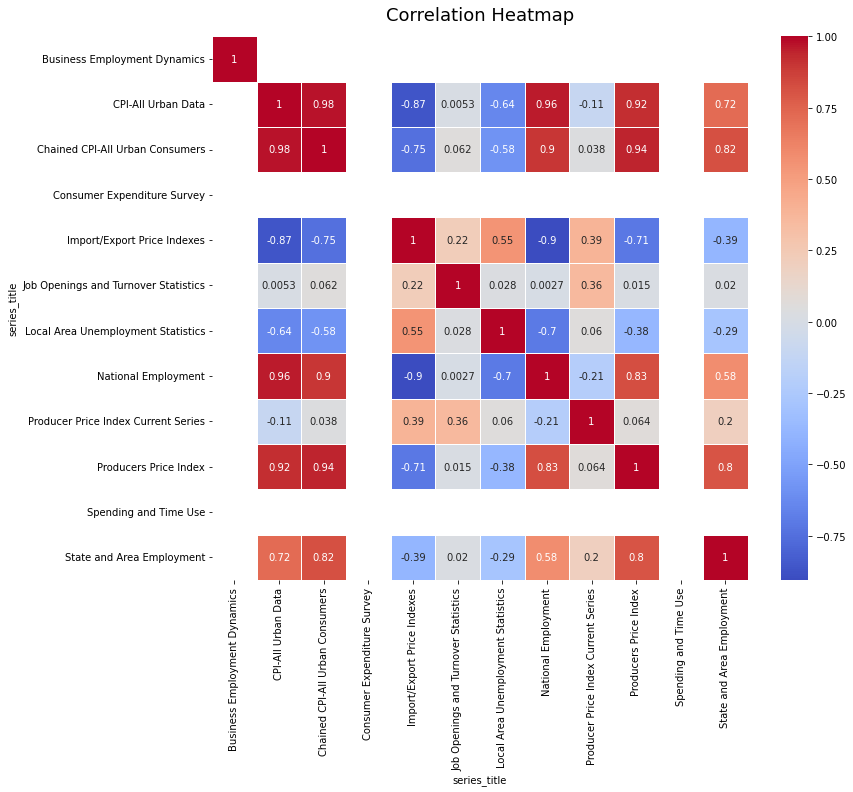

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

df = fetch_bls_data()

# Find the correlation of National Employment to all other statistics

df['value'] = pd.to_numeric(df['value'], errors='coerce')


pivot_df = df.pivot_table(index=['year', 'period'], columns='series_title', values='value')


correlation_matrix = pivot_df.corr()


plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=16)
plt.show()

## Dash App for the US Labour Of Statistics

In [3]:
import pandas as pd
import dash
from dash import dcc, html, Input, Output
import plotly.express as px

app = dash.Dash(__name__)


app.layout = html.Div([
    html.H1("U.S. Bureau of Labour Statistics", style={'textAlign':'center'}),

    
    html.Div([
       
        html.Div([
            html.Label("Year"),
            dcc.Dropdown(
                id='year-dropdown',
                options=[{'label': title, 'value': title} for title in df['year'].unique()],
                value=df['year'].unique()[0],
                style={'width': '300px'}
            )
        ], style={'display': 'inline-block', 'verticalAlign': 'top', 'marginRight': '10px'}),
    ]),

    
    html.Div(id='graphs', style={'display': 'flex', 'justify-content': 'space-around', 'flexWrap': 'wrap'})
])


@app.callback(
    Output('graphs', 'children'),
    [Input('year-dropdown', 'value')]
)
def update_graphs(selected_year):
    
    filtered_df = df[(df['year'] == selected_year) & (df['series_title'] == 'CPI-All Urban Data')
                     & (df['periodName'] != 'Annual')]

    filtered_df_emp = df[(df['year'] == selected_year) & (df['series_title'] == 'National Employment')
                         & (df['periodName'] != 'Annual')]

    
    cpi_y_max = df[df['series_title'] == 'CPI-All Urban Data']['value'].max()
    emp_y_max = df[df['series_title'] == 'National Employment']['value'].max()

    cpi_y_min = df[df['series_title'] == 'CPI-All Urban Data']['value'].min()
    emp_y_min = df[df['series_title'] == 'National Employment']['value'].min()

    
    line_chart = dcc.Graph(
        figure=px.line(
            filtered_df,
            x='periodName',
            y='value',
            title='Consumer Price Index',

            height=600,
            width=800
        ).update_traces(
            text=filtered_df['value'], 
            textposition='top left',
            mode='lines+markers', 
            marker=dict(size=8) 
        ).update_layout(
            margin=dict(l=40, r=40, t=40, b=40),
            title={'font': {'size': 20},'x': 0.5, 'xanchor': 'center'},
            yaxis=dict(range=[cpi_y_min * 0.9, cpi_y_max * 1.1]),
            xaxis_title='Month',
            yaxis_title=''
        )
    )

   
    line_chart_emp = dcc.Graph(
        figure=px.line(
            filtered_df_emp,
            x='periodName',
            y='value',
            title='National Employment',
            height=600,
            width=800
        ).update_traces(
            text=filtered_df_emp['value'],  
            textposition='top left',
            mode='lines+markers', 
            marker=dict(size=8)  
        ).update_layout(
            margin=dict(l=40, r=40, t=40, b=40),
            title={'font': {'size': 20},'x': 0.5, 'xanchor': 'center'},
            yaxis=dict(range=[emp_y_min * 0.9, emp_y_max * 1.1]), 
            xaxis_title='Month',
            yaxis_title=''
        )
    )

    return [line_chart, line_chart_emp]


if __name__ == '__main__':
    app.run_server(host='localhost', port=8050, debug=True, use_reloader=False,jupyter_mode='external')




Dash app running on http://localhost:8050/
